In [14]:
import sys
sys.path.append("../")

from tqdm import tqdm
import numpy as np
import pickle
import time

from network_model_cpt import *

from cpt_optimizer import MeanVarianceFrontierOptimizer
from cpt_utility import CPTUtility


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3,
                     "axes.grid": True,
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [7]:
with open("../graph.pickle", "rb") as f:
    graph = pickle.load(f)

In [8]:
communities = get_communities(graph)
community_membership = get_community_membership(graph, communities)

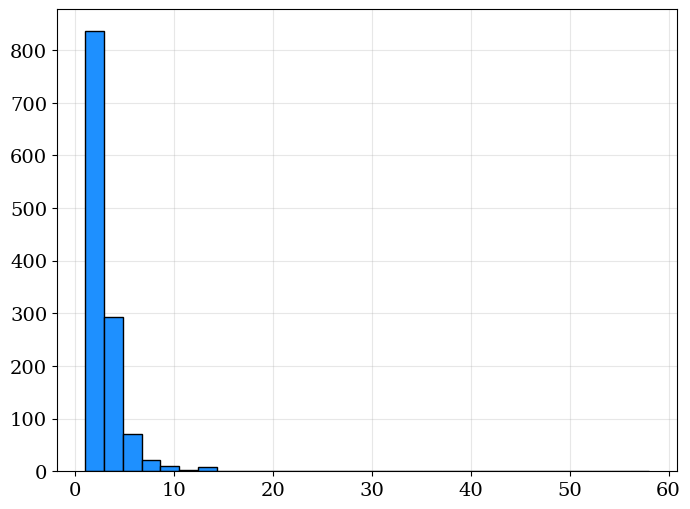

In [106]:
vals = [len(x)-1 for x in community_membership.values()]
plt.hist(vals, color="dodgerblue", edgecolor="k", bins=30)
plt.show()

In [107]:
from collections import Counter
dict(Counter(vals))

{1: 282,
 2: 554,
 5: 51,
 3: 207,
 10: 4,
 6: 20,
 4: 86,
 13: 7,
 9: 6,
 21: 1,
 7: 16,
 8: 6,
 14: 2,
 18: 1,
 12: 2,
 41: 1,
 19: 1,
 11: 1,
 58: 1,
 28: 1}

In [141]:
N = 2

# generate gamble returns
gambles = generate_gambles(N=N, gain_right_bound=1.7, prob_left=0.35)
gambles.append({"outcomes":[1.1,0.0], "probs":[1,0]})    
samples = 1000
gamble_returns = np.zeros((samples,len(gambles)))
for i,g in enumerate(gambles):
    gamble_returns[:,i] = np.random.choice(g["outcomes"], samples, p=g["probs"]) - 1

In [142]:
np.mean(gamble_returns, axis=0).round(3)

array([0.197, 0.25 , 0.1  ])

In [145]:
from SALib.sample import sobol

# problem definition
PROBLEM = {
    "num_vars" : 4,
    "names"    : ["gamma_pos",
                  "gamma_neg",
                  "delta_pos",
                  "delta_neg"],
    "bounds"   : [[5,40],
                  [41,80],
                  [0.30, 0.75],
                  [0.76, 0.95]]
}

# generate Saltelli samples
NUM_SAMPLES = 128
X = sobol.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)

In [146]:
results = []
for row in tqdm(X):
    utility = CPTUtility(gamma_pos=row[0], gamma_neg=row[1], delta_pos=row[2], delta_neg=row[3])
    mv = MeanVarianceFrontierOptimizer(utility)
    mv.optimize(gamble_returns)
    results.append(mv.weights)

100%|██████████| 768/768 [00:35<00:00, 21.54it/s]


In [147]:
mean_returns = np.mean(gamble_returns, axis=0).round(3)

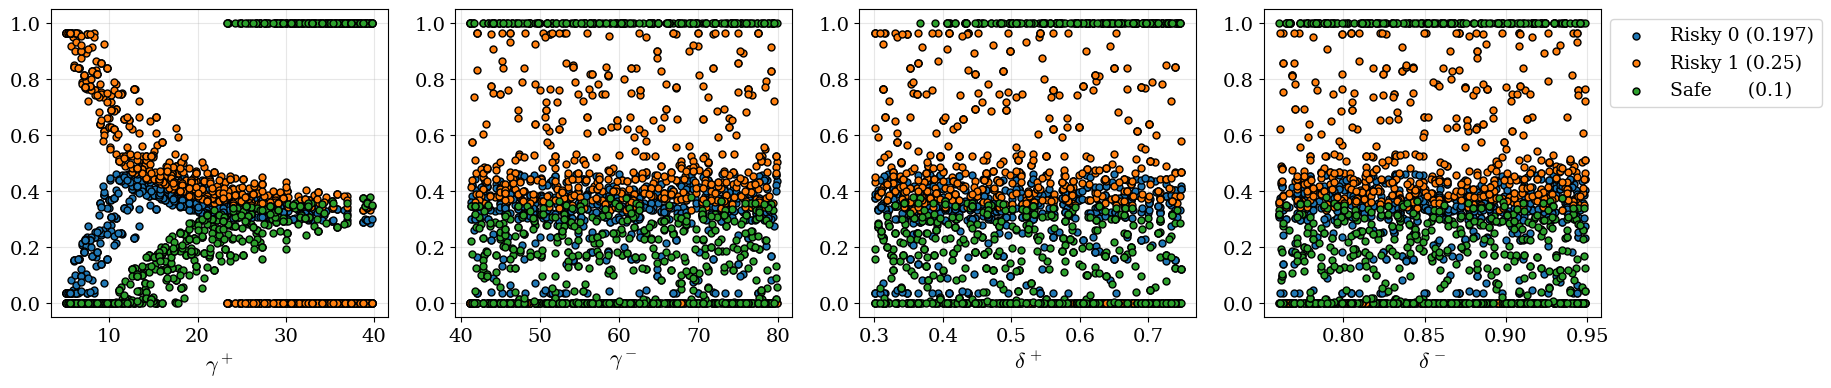

In [161]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))

xlabels = [r"$\gamma^+$", r"$\gamma^-$", r"$\delta^+$", r"$\delta^-$"]
labels = [rf"Risky {i} ({mean_returns[i]})" for i in range(len(mean_returns)-1)]
labels += ["Safe      (0.1)"]

for p_idx, PARAM_IDX in enumerate(range(4)): 
    for k in range(3):
        axs[p_idx].scatter([X[i][PARAM_IDX] for i in range(len(X))], 
                           [results[i][k].round(3) for i in range(len(results))],
                           label=labels[k],
                           edgecolor="k",
                           s=25)
        axs[p_idx].set_xlabel(xlabels[p_idx])
axs[-1].legend(bbox_to_anchor=(1,1))
plt.show()

In [11]:
%%time
W, A, U, P, T, C, S = simulation(PROJECT_COST=0.2, gain_right=1.75)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CPU times: user 9min 10s, sys: 15.3 s, total: 9min 25s
Wall time: 9min 44s


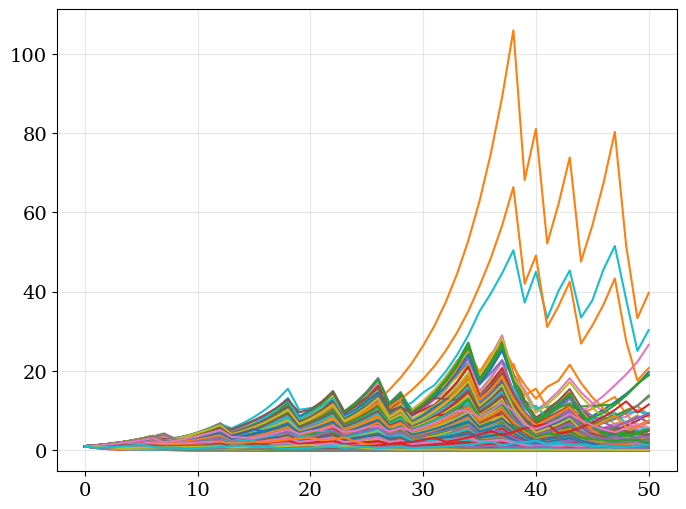

In [15]:
plt.plot(W)
plt.show()

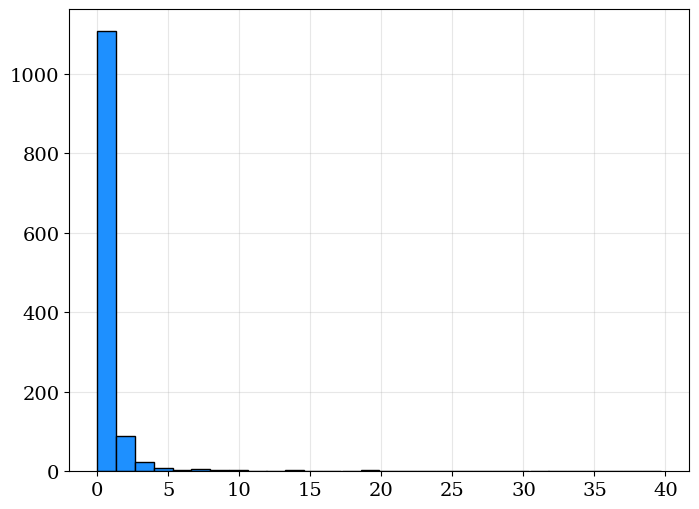

In [16]:
plt.hist(W[-1], color="dodgerblue", edgecolor="k", bins=30)
plt.show()